In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# Data Encoding and Scaling
from sklearn.preprocessing import OrdinalEncoder, RobustScaler, StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn import set_config

# Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
warnings.filterwarnings('ignore')

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [4]:
df = pd.read_csv('try_data_processed.csv')

In [5]:
df.head()

,jobma_catcher_id,is_premium,jobma_verified,subscription_status,company_size,plan_type,is_unlimited,jobma_catcher_sub_accounts,subscription_amount,number_of_subscriptions,number_of_invitations,job_posted,number_of_kits,number_of_recorded_interviews,number_of_live_interviews
0,2656,0,1,1,1-25,0,1,0,15000.00,1,4,1,2,1,0
1,2935,0,1,2,26-100,1,0,0,53.10,1,74,4,0,0,0
2,2937,0,1,2,101-500,1,0,0,118.00,1,74,4,0,0,0
3,2938,0,1,1,26-100,1,0,0,15200.18,3,74,1,0,0,0
4,2939,0,1,2,26-100,1,0,0,11800.00,1,74,1,0,0,0


In [6]:
df.columns

Index(['jobma_catcher_id', 'is_premium', 'jobma_verified',
       'subscription_status', 'company_size', 'plan_type', 'is_unlimited',
       'jobma_catcher_sub_accounts', 'subscription_amount',
       'number_of_subscriptions', 'number_of_invitations', 'job_posted',
       'number_of_kits', 'number_of_recorded_interviews',
       'number_of_live_interviews'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6116 entries, 0 to 6115
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   jobma_catcher_id               6116 non-null   int64  
 1   is_premium                     6116 non-null   int64  
 2   jobma_verified                 6116 non-null   int64  
 3   subscription_status            6116 non-null   int64  
 4   company_size                   6116 non-null   object 
 5   plan_type                      6116 non-null   int64  
 6   is_unlimited                   6116 non-null   int64  
 7   jobma_catcher_sub_accounts     6116 non-null   int64  
 8   subscription_amount            6116 non-null   float64
 9   number_of_subscriptions        6116 non-null   int64  
 10  number_of_invitations          6116 non-null   int64  
 11  job_posted                     6116 non-null   int64  
 12  number_of_kits                 6116 non-null   i

# Use this for merging in the end

In [9]:
''' Backup DataFrame '''
backup_df = df.copy()

In [10]:
df.drop(['jobma_catcher_id', 'jobma_verified'], axis=1, inplace=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6116 entries, 0 to 6115
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   is_premium                     6116 non-null   int64  
 1   subscription_status            6116 non-null   int64  
 2   company_size                   6116 non-null   object 
 3   plan_type                      6116 non-null   int64  
 4   is_unlimited                   6116 non-null   int64  
 5   jobma_catcher_sub_accounts     6116 non-null   int64  
 6   subscription_amount            6116 non-null   float64
 7   number_of_subscriptions        6116 non-null   int64  
 8   number_of_invitations          6116 non-null   int64  
 9   job_posted                     6116 non-null   int64  
 10  number_of_kits                 6116 non-null   int64  
 11  number_of_recorded_interviews  6116 non-null   int64  
 12  number_of_live_interviews      6116 non-null   i

In [12]:
''' This Function is to fill all missing values (if col is int then 0, if col is float then 0.0 and if col is object then 'Unkmown') '''

def fill_missing_values(df):
    df = df.copy()
    for col in df.columns:
        if df[col].dtype == np.int64:
            df[col].fillna(0, inplace=True)
        elif df[col].dtype == np.float64:
            df[col].fillna(0.0, inplace=True)
        elif df[col].dtype == object:
            unique_vals = df[col].dropna().unique()
            if set(unique_vals).issubset({'Yes', 'No'}):
                df[col].fillna('No', inplace=True)
            else:
                df[col].fillna('Unknown', inplace=True)
    return df

# Data Encoding

In [14]:
def ordinal_encoder(df):
    # Define the ordinal column and the ordering
    ordinal_col = ['company_size']
    company_size_order = ['Unknown', '1-25', '26-100', '101-500', '500-1000', 'More than 1000']
    
    # Initialize OrdinalEncoder with specified categories
    ordinal = OrdinalEncoder(categories=[company_size_order])
    
    # Fit and transform the data (make sure input is 2D for encoding)
    encoded = ordinal.fit_transform(df[ordinal_col].astype(str).values.reshape(-1, 1))
    
    # Convert the encoded result to a DataFrame with the appropriate column name
    encoded_df = pd.DataFrame(encoded, columns=[f'{col}_ord' for col in ordinal_col], index=df.index)

    # Drop the original column
    df.drop(columns=ordinal_col, inplace=True)

    # Concatenate the encoded column to the original dataframe
    df = pd.concat([df, encoded_df], axis=1)
    
    return df

# Log Transformation

In [16]:
log_cols = [
    'jobma_catcher_sub_accounts',
    'subscription_amount',
    'number_of_subscriptions'
    'number_of_invitations',
    'job_posted',
    'number_of_kits',
    'number_of_recorded_interviews',
    'number_of_live_interviews'
]

In [17]:
def log_transform(df):
    df = df.copy()
    for col in log_cols:
        if col in df.columns:
            # fill NaNs
            df[col] = df[col].fillna(0)
            # if a number is less than zero, turn it into zero;
            df[col] = df[col].clip(lower=0)
            # safe log1p
            df[col] = np.log1p(df[col])
            
    return df

# Pipeline

In [19]:
pipeline = Pipeline([
    ('fill_missing_values', FunctionTransformer(fill_missing_values, validate=False)),
    ('ordinal_encoder', FunctionTransformer(ordinal_encoder, validate=False)),
    ('log_transformation', FunctionTransformer(log_transform, validate=False)), # log transforms the col with outliers
    ('scaler', StandardScaler()), # Needs attention to improve model
    # ('pca', PCA(n_components=0.95))
])

In [20]:
set_config(display='diagram')
pipeline

Pipeline(steps=[('fill_missing_values',
                 FunctionTransformer(func=<function fill_missing_values at 0x00000193C1D1E660>)),
                ('ordinal_encoder',
                 FunctionTransformer(func=<function ordinal_encoder at 0x00000193C1D1EA20>)),
                ('log_transformation',
                 FunctionTransformer(func=<function log_transform at 0x00000193C1D1E980>)),
                ('scaler', StandardScaler())])

# Data Splitting

In [22]:
X = df

In [23]:
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

In [24]:
type(X_train), type(X_test)

(pandas.core.frame.DataFrame, pandas.core.frame.DataFrame)

In [25]:
len(X_train), len(X_test)

(4892, 1224)

# Fit Pipeline

In [27]:
X_train_transformed = pipeline.fit_transform(X_train)
X_test_transformed = pipeline.transform(X_test)

In [28]:
type(X_train_transformed), type(X_test_transformed)

(numpy.ndarray, numpy.ndarray)

In [29]:
len(X_train_transformed), len(X_test_transformed)

(4892, 1224)

In [30]:
features_names = df.columns

In [31]:
X_df = pd.DataFrame(X_train_transformed, columns=features_names)
# X_df = pd.DataFrame(X_train_transformed)

In [32]:
X_df.columns

Index(['is_premium', 'subscription_status', 'company_size', 'plan_type',
       'is_unlimited', 'jobma_catcher_sub_accounts', 'subscription_amount',
       'number_of_subscriptions', 'number_of_invitations', 'job_posted',
       'number_of_kits', 'number_of_recorded_interviews',
       'number_of_live_interviews'],
      dtype='object')

# Convert into Tensor

In [34]:
X_train_tensor = torch.tensor(X_train_transformed, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_transformed, dtype=torch.float32).to(device)

In [35]:
type(X_train_tensor), type(X_test_tensor)

(torch.Tensor, torch.Tensor)

# Dataset Class

In [37]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [38]:
train_data = CustomDataset(X_train_tensor)
test_data = CustomDataset(X_test_tensor)

# DataLoader

In [40]:
BATCH_SIZE = 16

In [41]:
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [42]:
len(train_data), len(test_data)

(4892, 1224)

In [43]:
len(train_dataloader), len(test_dataloader)

(306, 77)

# Define a Model (AutoEncoder in this case)

In [45]:
class AutoEncoder(nn.Module):
    def __init__(self, input_shape):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_shape, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)  # bottleneck
        )

        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_shape)
        )

    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [46]:
''' Initializing the Model '''

input_shape = X_df.shape[1]
model_1 = AutoEncoder(input_shape)
model_1.to(device)

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=13, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=13, bias=True)
  )
)

In [47]:
''' Important Parameters '''
learning_rate = 0.001
epochs = 50

In [48]:
''' Loss Function and Optimizers '''

# mse_loss_function = nn.MSELoss()
mse_loss_function = nn.SmoothL1Loss()
optimizer = torch.optim.AdamW(model_1.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

# Training Loop

In [50]:
def train_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               mse_loss_function:torch.nn.Module,
               optimizer:torch.optim.Optimizer
              ):
    model.train()
    epoch_total_loss = 0

    for batch_X in dataloader:
        encoded, decoded = model(batch_X)

        ''' Compute Loss '''
        mse_loss = mse_loss_function(decoded, batch_X)

        ''' BackPropagation '''
        optimizer.zero_grad()
        mse_loss.backward()
        optimizer.step()

        epoch_total_loss += mse_loss.item()

    training_loss = epoch_total_loss / len(dataloader)
    return training_loss

# Testing Loop

In [52]:
def test_step(model:torch.nn.Module,
              dataloader:torch.utils.data.DataLoader,
              mse_loss_function:torch.nn.Module,
             ):

    epoch_total_loss = 0
    
    model.eval()
    with torch.inference_mode():
        for batch_X in dataloader:
            encoded, decoded = model(batch_X)  # Forward pass

            ''' Compute Loss '''
            mse_loss = mse_loss_function(decoded, batch_X)  # Reconstruction Loss
            
            epoch_total_loss += mse_loss.item()

        testing_loss = epoch_total_loss / len(dataloader)
        return testing_loss

# Combining Training and Testing Loop into evaluate()

In [54]:
def evaluate(model:torch.nn.Module,
             train_dataloader:torch.utils.data.DataLoader,
             test_dataloader:torch.utils.data.DataLoader,
             mse_loss_function:torch.nn.Module,
             optimizer:torch.optim.Optimizer,
             scheduler:torch.optim.lr_scheduler.ReduceLROnPlateau,
             epochs:int = 5,
             patience:int = 5,
             delta:float = 0.0001
            ):
    
    results = {'training_loss':[],
              'testing_loss':[]}

    best_testing_loss = float('inf')
    epochs_without_improvement = 0

    for epoch in range(epochs):
        training_loss = train_step(model=model,
                                   dataloader=train_dataloader,
                                   mse_loss_function=mse_loss_function,
                                   optimizer=optimizer
                                  )

        testing_loss = test_step(model=model,
                                   dataloader=test_dataloader,
                                   mse_loss_function=mse_loss_function,
                                  )

        scheduler.step(testing_loss)
        results['training_loss'].append(training_loss)
        results['testing_loss'].append(testing_loss)

        print(f'Epoch {epoch+1}/{epochs} | Training Loss: {training_loss:.5f} | Testing Loss: {testing_loss:.5f}')

         # Early stopping: check if testing loss improved
        if testing_loss < best_testing_loss - delta:
            best_testing_loss = testing_loss
            epochs_without_improvement = 0  # Reset counter since we had improvement
        else:
            epochs_without_improvement += 1
        
        # If no improvement for 'patience' epochs, stop training early
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}!")
            break
        
        # LR Scheduler
        for param_group in optimizer.param_groups:
            print(f"Current Learning Rate: {param_group['lr']:.6f}")
    return results

In [55]:
results = evaluate(model=model_1,
                   train_dataloader=train_dataloader,
                   test_dataloader=test_dataloader,
                   mse_loss_function=mse_loss_function,
                   optimizer=optimizer,
                   scheduler=scheduler,
                   epochs=epochs,
                   patience=5,  # Stop after 3 epochs without improvement
                   delta=0.0001)

Epoch 1/50 | Training Loss: 0.15963 | Testing Loss: 0.08174
Current Learning Rate: 0.001000
Epoch 2/50 | Training Loss: 0.07532 | Testing Loss: 0.04909
Current Learning Rate: 0.001000
Epoch 3/50 | Training Loss: 0.05640 | Testing Loss: 0.03695
Current Learning Rate: 0.001000
Epoch 4/50 | Training Loss: 0.04841 | Testing Loss: 0.02920
Current Learning Rate: 0.001000
Epoch 5/50 | Training Loss: 0.04378 | Testing Loss: 0.02414
Current Learning Rate: 0.001000
Epoch 6/50 | Training Loss: 0.03967 | Testing Loss: 0.02738
Current Learning Rate: 0.001000
Epoch 7/50 | Training Loss: 0.03816 | Testing Loss: 0.02402
Current Learning Rate: 0.001000
Epoch 8/50 | Training Loss: 0.03533 | Testing Loss: 0.02061
Current Learning Rate: 0.001000
Epoch 9/50 | Training Loss: 0.03346 | Testing Loss: 0.02022
Current Learning Rate: 0.001000
Epoch 10/50 | Training Loss: 0.03235 | Testing Loss: 0.01918
Current Learning Rate: 0.001000
Epoch 11/50 | Training Loss: 0.03154 | Testing Loss: 0.01962
Current Learning R

# Loss and Accuracy Curves

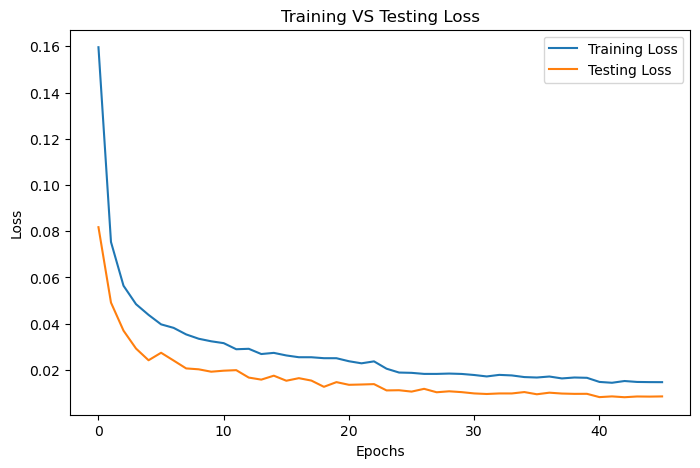

In [57]:
epochs = range(len(results['training_loss']))

plt.figure(figsize=(8, 5))
plt.plot(epochs, results['training_loss'], label='Training Loss')
plt.plot(epochs, results['testing_loss'], label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training VS Testing Loss')
plt.legend()
plt.show()

# Clustering

In [59]:
model_1.eval()

with torch.no_grad():
    encoder, _ = model_1(X_train_tensor)

latent_np = encoder.cpu().numpy()

In [60]:
wcss = []
silhouette_scores = []
k_range = range(2,11)

In [61]:
torch.manual_seed(42)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(latent_np)
    
    wcss.append(kmeans.inertia_)  # Inertia = WCSS
    silhouette_scores.append(silhouette_score(latent_np, labels))

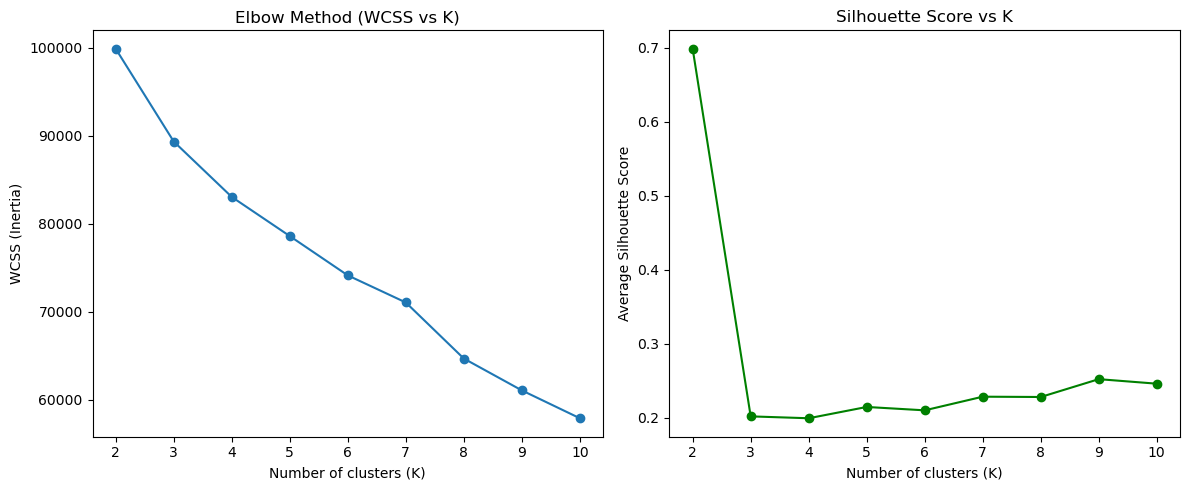

In [62]:
''' Elbow Rule to decide the number of clusters '''
torch.manual_seed(42)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, wcss, marker='o')
plt.title('Elbow Method (WCSS vs K)')
plt.xlabel('Number of clusters (K)')
plt.ylabel('WCSS (Inertia)')

# Step 5: Plot Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o', color='green')
plt.title('Silhouette Score vs K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Average Silhouette Score')

plt.tight_layout()
plt.show()

In [63]:
#Initialising KMeans
kmeans = KMeans(n_clusters=4, n_init=50, init='k-means++', random_state=42)
cluster_ids = kmeans.fit_predict(latent_np)
cluster_centers = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32).to(device)

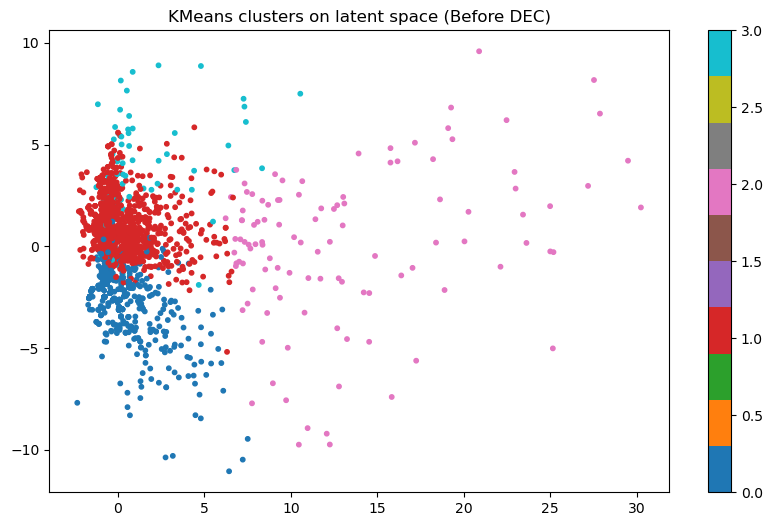

In [64]:
latent_2d = PCA(n_components=2).fit_transform(latent_np)
plt.figure(figsize=(10, 6))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=cluster_ids, cmap='tab10', s=10)
plt.title("KMeans clusters on latent space (Before DEC)")
plt.colorbar()
plt.show()

## Test it on User's Preferences 

In [66]:
X_df.columns

Index(['is_premium', 'subscription_status', 'company_size', 'plan_type',
       'is_unlimited', 'jobma_catcher_sub_accounts', 'subscription_amount',
       'number_of_subscriptions', 'number_of_invitations', 'job_posted',
       'number_of_kits', 'number_of_recorded_interviews',
       'number_of_live_interviews'],
      dtype='object')

In [67]:
backup_df = backup_df[['jobma_catcher_id',
                       'is_premium',
                         'subscription_status',
                         'company_size',
                         'plan_type',
                         'is_unlimited',
                         'jobma_catcher_sub_accounts',
                         'subscription_amount',
                         'number_of_subscriptions',
                         'number_of_invitations',
                         'job_posted',
                         'number_of_kits',
                         'number_of_recorded_interviews',
                        'number_of_live_interviews']]

In [68]:
user_pref_good = {'is_premium':'0',
             'subscription_status':0,
             'company_size':'500-1000',
             'plan_type':'0',
             'is_unlimited':'0',
             'jobma_catcher_sub_accounts':115,
             'subscription_amount': 118872599.99,
             'number_of_subscriptions':20.,
             'number_of_invitations':131,
             'job_posted':35.,
             'number_of_kits':31.,
             'number_of_recorded_interviews':181,
            'number_of_live_interviews':225  
            }

In [69]:
compare_df = pd.read_csv('try_data_processed.csv')

In [70]:
compare_df.columns

Index(['jobma_catcher_id', 'is_premium', 'jobma_verified',
       'subscription_status', 'company_size', 'plan_type', 'is_unlimited',
       'jobma_catcher_sub_accounts', 'subscription_amount',
       'number_of_subscriptions', 'number_of_invitations', 'job_posted',
       'number_of_kits', 'number_of_recorded_interviews',
       'number_of_live_interviews'],
      dtype='object')

In [71]:
def recommend(user_input, model, dataloader, compare_df, backup_df, pipeline, top_k=5):
    user_df = pd.DataFrame([user_input])
    user_input_transformed = pipeline.transform(user_df)
    user_input_tensor = torch.tensor(user_input_transformed, dtype=torch.float32)

    model.eval()
    with torch.no_grad():
        user_embedding, _ = model(user_input_tensor)
        item_embeddings_list = []
        for batch_X in dataloader:
            item_embedding, _ = model(batch_X)
            item_embeddings_list.append(item_embedding)

        item_embeddings = torch.cat(item_embeddings_list, dim=0)

        similarities = F.cosine_similarity(user_embedding, item_embeddings, dim=1)
        top_indices = similarities.topk(top_k).indices.cpu().numpy()

    recommended = compare_df.iloc[top_indices].copy()
    recommended['similarity'] = similarities[top_indices].cpu().numpy()
    recommended = recommended[['jobma_catcher_id', 'similarity']]
    merged_df = pd.merge(recommended, backup_df, on='jobma_catcher_id', how='inner')

    return merged_df

In [72]:
result = recommend(user_pref_good, model_1, test_dataloader, compare_df, backup_df, pipeline, top_k=5)
result.head(5)

,jobma_catcher_id,similarity,is_premium,subscription_status,company_size,plan_type,is_unlimited,jobma_catcher_sub_accounts,subscription_amount,number_of_subscriptions,number_of_invitations,job_posted,number_of_kits,number_of_recorded_interviews,number_of_live_interviews
0,3824,0.733944,0,2,1-25,1,0,0,33.6,2,74,4,0,0,0
1,3624,0.720095,1,2,26-100,1,0,0,23600.0,1,74,4,0,0,0
2,4236,0.717947,0,2,26-100,0,0,0,0.0,1,74,4,0,0,0
3,4045,0.692973,1,2,26-100,1,0,0,1180.0,1,74,4,0,0,0
4,4002,0.685416,0,2,500-1000,1,0,0,11800354.0,7,74,4,0,0,0


In [73]:
user_pref_test = {'is_premium':'0',
             'subscription_status':2,
             'company_size':'1-25',
             'plan_type':'0',
             'is_unlimited':'1',
             'jobma_catcher_sub_accounts':0,
             'subscription_amount': 199.0,
             'number_of_subscriptions':2,
             'number_of_invitations':74,
             'job_posted':4,
             'number_of_kits':0,
             'number_of_recorded_interviews':0,
            'number_of_live_interviews':0  
            }

In [74]:
result1 = recommend(user_pref_test, model_1, test_dataloader, compare_df, backup_df, pipeline, top_k=5)
result1.head(5)

,jobma_catcher_id,similarity,is_premium,subscription_status,company_size,plan_type,is_unlimited,jobma_catcher_sub_accounts,subscription_amount,number_of_subscriptions,number_of_invitations,job_posted,number_of_kits,number_of_recorded_interviews,number_of_live_interviews
0,3226,0.994499,1,2,26-100,1,1,0,141.6,1,74,4,0,0,0
1,3378,0.994499,1,2,1-25,1,1,0,10000.0,1,74,4,0,0,0
2,3444,0.994499,1,2,1-25,0,0,0,50.0,1,74,4,0,0,0
3,3571,0.994456,0,2,1-25,1,0,0,118.0,1,74,4,0,0,0
4,2941,0.990482,0,2,26-100,1,0,0,11800.0,1,74,1,0,0,0
